In [1]:
# Base libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
from itertools import repeat
import math

# Necessary libraries for MCMC sampling
import os
os.environ['CMDSTAN'] = '/Users/michelafrigeri/.cmdstan/cmdstan-2.33.1'
from cmdstanpy import cmdstan_path, CmdStanModel
import arviz as az
import seaborn as sns

import xarray as xr
xr.set_options(display_expand_data=False, display_expand_attrs=False);

In [2]:
# Disable warnings for MCMC
import warnings
warnings.filterwarnings('ignore')

# Cecking the right path for Stan
cmdstan_path()

***
# THE PM$_{10}$ DATASET
***

In this project we want to build a **Bayesian spatio-temporal model for PM$_{10}$** emissions in **Emilia-Romagna**. Concentrations of pollutant are recorded at different monitoring sites during 2018, reporting also territorial characteristics of each site. 
Pianura Padana is a well-known hot-spot for air pollution. Here the main factors contributing to PM$_{10}$ emissions are high popukation density, massive agriculture and industrial activities, beside the dense network of roads and motorways. Providing a model able to describe how PM$_{10}$ concentration varies in space and time is of major interest to address the air quality problem. 
The data used in this project have been collected by _ARPA Emilia-Romagna_ monitoring network **from 01/01/2018 to 31/12/2018**.

## Data description
The dataset we use contains the **daily concentration** of PM$_{10}$ in 2018, collected by monitoring stations across Emilia-Romagna, together with territorial characteristics of the stations themselves.

In [3]:
# Importing the data
df = pd.read_csv("Py_Dataset.csv")
df.head()

Unnamed: 0        Date     Y_log  Rural  Time     NS     quota Provincia  \
0           1  2018-01-01  3.688645      1     0  BADIA  0.522332        PR   
1           2  2018-01-02  2.743930      1     1  BADIA  0.522332        PR   
2           3  2018-01-03  2.687557      1     2  BADIA  0.522332        PR   
3           4  2018-01-04  2.850192      1     3  BADIA  0.522332        PR   
4           5  2018-01-05  3.558992      1     4  BADIA  0.522332        PR   

    Zonizzazione   Tipo  id  
0  Pianura Ovest  Fondo   1  
1  Pianura Ovest  Fondo   1  
2  Pianura Ovest  Fondo   1  
3  Pianura Ovest  Fondo   1  
4  Pianura Ovest  Fondo   1

In particular, we have:
* Date: full date in which the observation was registered (year-month-day);
* Y_log: logarithmic transformation of PM$_{10}$ daily concentrations;
* Rural: whether the station belongs to _Rural_ (Rural==1) or _Suburban/Urban_ (Rural==0) area; 
* Time: day of the year ($t=0,\dots,364$) in which the registration took place;
* Station’s Name: we have _49 monitoring stations_ in Emilia-Romagna;
* Altitude: height from sea level at which PM$_{10}$ is measured (depends on stations' location);
* Province: territorial province;
* Zoning: specific spatial categorization of each region. Here we have four levels: Conurbation, Appennino, Est Plain, West Plain;
* Type: whether the station is chategorized as _Traffic, Industrial_ or _Background_ (depends on closeness to specific pollution sources).

In this field of study it is very common to use logarithmic concentrations of pollutants instead of the raw observed data. This choice is due to the tendency of concentration data to have heavy tailed distributions over larger values. Since this behavior could provide misleading results when studying the phenomenon, it is a standard practice to provide data analysis over **$\log(PM_{10})$** daily values.

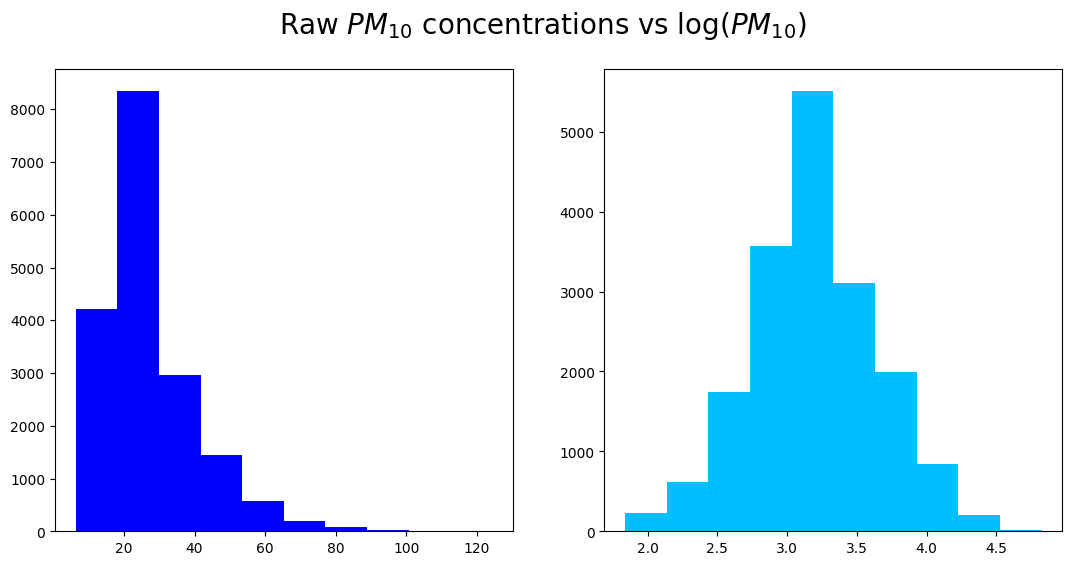

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
fig.suptitle('Raw $PM_{10}$ concentrations vs $\log(PM_{10})$', fontsize=20)
ax1.hist(np.exp(df.Y_log), color='blue')
ax2.hist(df.Y_log, color='deepskyblue')
fig.subplots_adjust(hspace=0.3)

# Graphical exploration of $\log(PM_{10})$ Time Series
We provide here a plot of the 49 time series (one for each station) of daily $\log(PM_{10})$ values. Each time series is coloured according to the corresponding station being located in a **Rural** (green) or **NON rural** (orange) area.

We can see from the plots that Rural and NON-rural stations seem to follow different overall trends. This information will be included in the Bayesian modeling framework by providing different parameters for these two main groups.

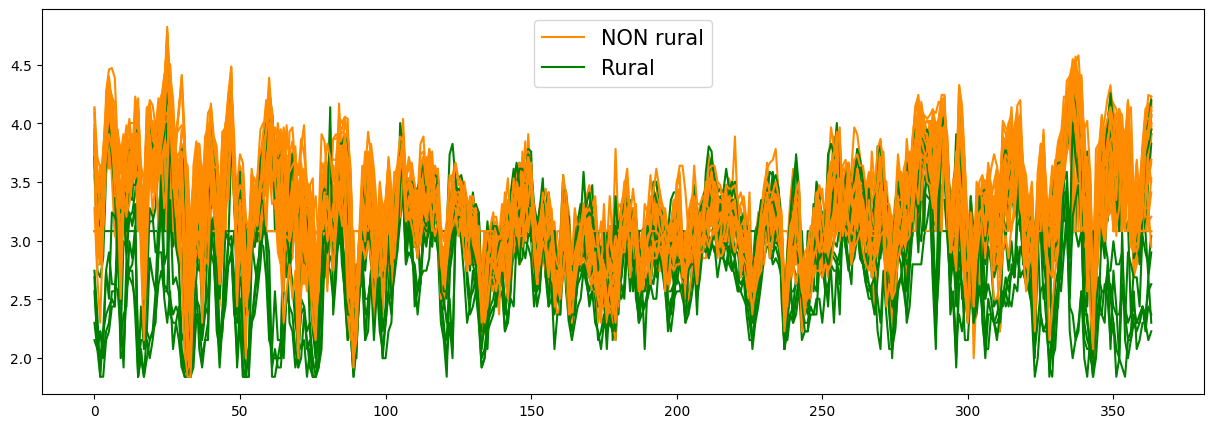

In [5]:
# Grafico esplorativo
data = df.set_index('Time')
col = ["darkorange", "green"]
plt.figure(figsize=(15, 5))
for j in range(49):
        temp = data.iloc[364*j:(364*(j+1)),:]
        plt.plot(temp.index, temp.Y_log, color=col[temp.Rural.iloc[0]])
plt.legend(labels=['NON rural', 'Rural'], fontsize=15)
ax = plt.gca()
leg = ax.get_legend()
leg.legend_handles[0].set_color('darkorange')
leg.legend_handles[1].set_color('green')

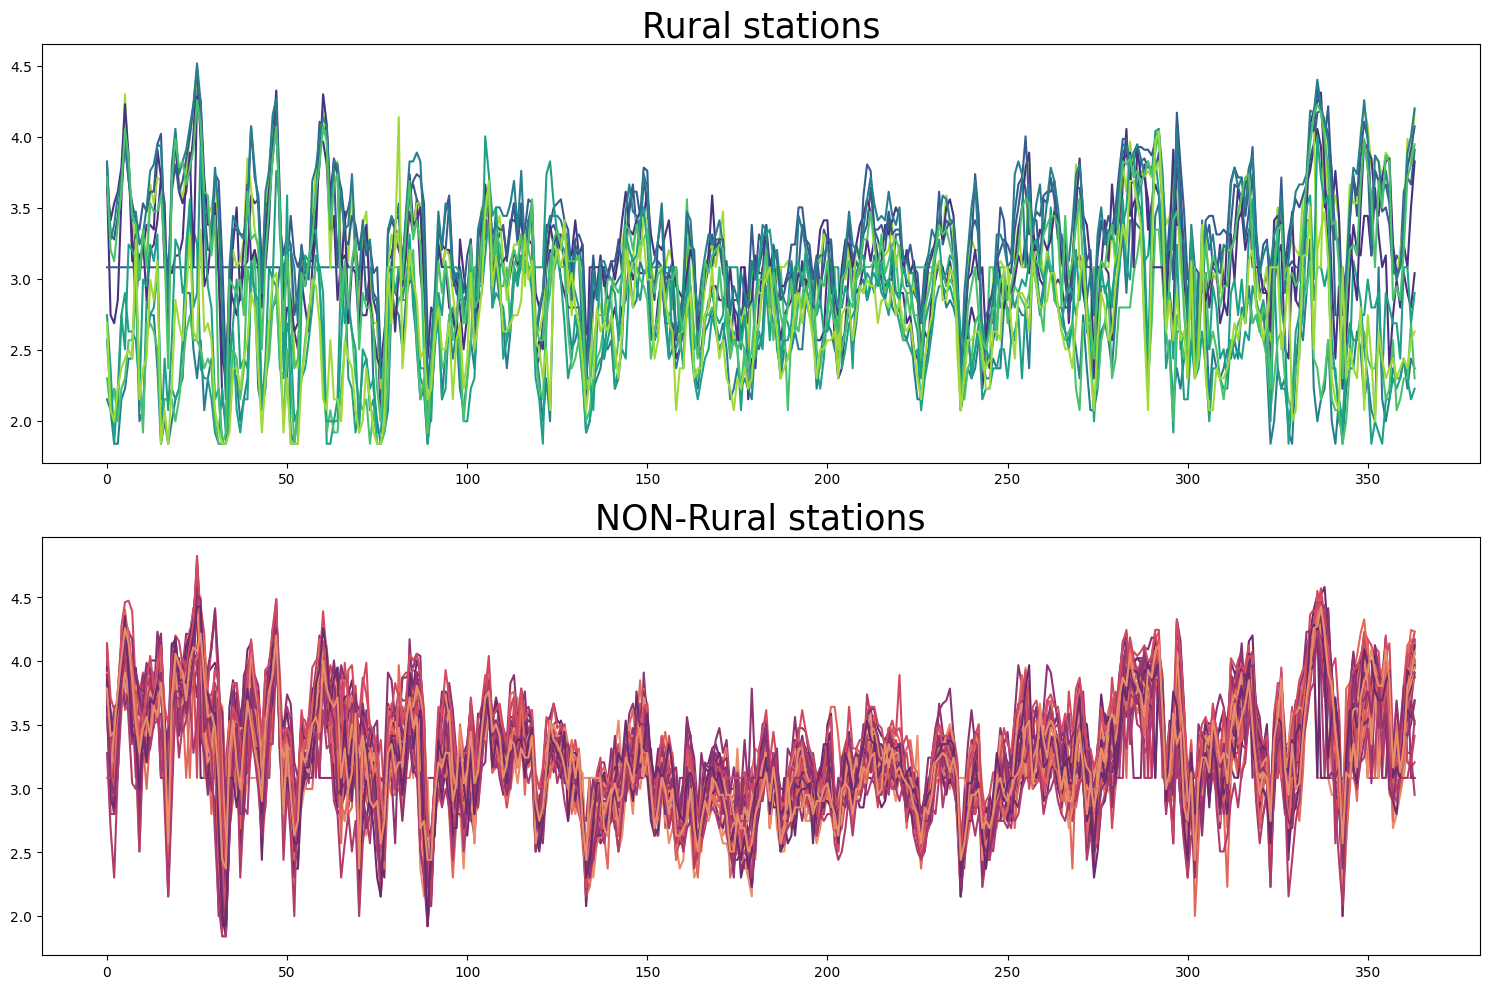

In [51]:
rural = data[data["Rural"]==1]
Nr = len(rural.NS.unique())
NONrural = data[data["Rural"]==0]
N = len(NONrural.NS.unique())

# First subplot
sns.set_palette("viridis")
plt.figure(figsize=(15,10))
plt.subplot(2, 1, 1)
plt.title("Rural stations", fontsize=25)
for j in range(Nr):
        temp = rural.iloc[364*j:(364*(j+1)),:]
        plt.plot(temp.index, temp.Y_log)  

# Second subplot
sns.set_palette("flare")
plt.subplot(2, 1, 2)
plt.title("NON-Rural stations", fontsize=25)
for j in range(N):
        temp = NONrural.iloc[364*j:(364*(j+1)),:]
        plt.plot(temp.index, temp.Y_log)

sns.set_palette(sns.color_palette("tab10"))
plt.tight_layout()
plt.show()


In [7]:
# Dummy variables for station types
dummies = pd.get_dummies(df.Tipo)
dummies.head()

Fondo  Industriale  Traffico
0   True        False     False
1   True        False     False
2   True        False     False
3   True        False     False
4   True        False     False

***
# BAYESIAN MODELING WITH _STAN_
***

We want to implement the following model in a Bayesian framework:

$y_i(t) = f_i(t) + X_i \beta + \epsilon_{i,t} , \qquad \epsilon_{i,t} \sim \mathcal{N}(0, \sigma^2)\ \ $ iid

$f_i(t) = c_k + \sum_{k=0}^{k=K} a_k \sin(k\omega t) + b_k \cos(k\omega t)$

where: $i=1,\dots,49$ specifies the station while $t=0,\dots,364$ specifies the day of the year.
To provide **Bayesian posterior inference**, we must implement our model in _Stan_ that will provide us **MCMC samplings** to use for posterior densities estimate.

### Input data 
- `int` N = len(Y) = number of total samples 
- `int` K = number of different frequencies for Fourier basis (here K=3)
- `int` p = number of regressors (here p=3 : _quota_ & _tipo_(dummyx2))

- `vector[N]` y = $\log(PM_{10})$ time series
- `matrix[N, p]` x = covariates matrix
- `vector[N]` t = time istant
- `vector[N]` r = 1 if rural, 0 otherwise
- `real` omega = annual frequency = 2$\pi$/365


### Model parameters

- `vector[K]` a =  $\sin(k\omega t)$ coefficients ($k=1,2,3$)
- `vector[K]` b = $\cos(k\omega t)$ coefficients ($k=1,2,3$)
- `real` c = constant term for $f(t)$

- `vector[K]` a_r = $\sin(k\omega t)$ coefficients ($k=1,2,3$) _rural_
- `vector[K]` b_r = $\cos(k\omega t)$ coefficients ($k=1,2,3$) _rural_
- `real` c_r = constant term for $f_r(t)$ _rural_

- `vector[p]` beta = linear regressors' coefficients
- `real` sigma_sq = variance of the error term $\epsilon$


***
### _Stan_ modeling
***

In [8]:
fourier = """
data {
    int<lower=0> N; 
    int<lower=0> K;
    int<lower=0> p;
    
    vector[N] Y;
    matrix[N, p] X;
    vector[N] t;
    vector[N] r;
    real omega;
}

parameters {

    real<lower=0> sigma_sq;
    
    vector[p] beta;
    
    vector[K] a;
    vector[K] b;
    real c;
    
    vector[K] a_r;
    vector[K] b_r;
    real c_r;
    
}


transformed parameters {
    
    vector[N] ft = to_vector(rep_array(c, N));
    vector[N] ft_r = to_vector(rep_array(c_r, N));
    
    for (j in 1:K){
     ft += a[j]*sin(j*omega*t) + b[j]*cos(j*omega*t);
     ft_r += a_r[j]*sin(j*omega*t) + b_r[j]*cos(j*omega*t);
    }
    
    vector[N] mu;
    mu = rows_dot_product(r, ft_r) + rows_dot_product(1-r, ft) + X*beta ;
}

model {  

    sigma_sq ~ inv_gamma(3, 2);
    
    beta ~ normal(0, 1);
    
    a ~ normal(0, 1);
    b ~ normal(0, 1);
    c ~ normal(0, 1);
    
    a_r ~ normal(0, 1);
    b_r ~ normal(0, 1);
    c_r ~ normal(0, 1);
    
    Y ~ normal(mu, sqrt(sigma_sq));  
}

generated quantities  {
  vector[N] log_lik;
  for (j in 1:N) {
    log_lik[j] = normal_lpdf(Y[j] | mu[j], sqrt(sigma_sq));
  }
}
"""

stan_file = "./fourier.stan"

with open(stan_file, "w") as f:
    print(fourier, file=f)

fourier = CmdStanModel(stan_file=stan_file)

15:45:30 - cmdstanpy - INFO - compiling stan file /Users/michelafrigeri/Desktop/PDL/fourier.stan to exe file /Users/michelafrigeri/Desktop/PDL/fourier
15:45:55 - cmdstanpy - INFO - compiled model executable: /Users/michelafrigeri/Desktop/PDL/fourier


***
### _Stan_ input data & Sampling
***

In [10]:
y = np.array(df.Y_log)
N = len(y)
k = 3   # 6 Fourier basis + const
p = 3   # Altitude & StationType(2 dummies)
x = np.matrix( pd.concat([df.quota, dummies.Fondo, dummies.Industriale], axis=1) )
t = np.array(df.Time)
r = np.array(df.Rural)
omega = 2*np.pi/365

# List of input data for Stan MCMC
reg_data = {
    "N": N,   # 18 000 circa (49x365)
    "K": k,   # Fbasis number
    "p": p,   # 3
    
    "Y": y,
    "X": x, 
    "t": t,
    "r": r,   
    "omega": omega }

In [11]:
# WARNING: This slot takes some time ~ 3 to 5 minutes
t_start = time.time()

fourier_fit = fourier.sample(data = reg_data, 
                             chains = 2, 
                             parallel_chains = 2, 
                             iter_warmup = 800, 
                             iter_sampling = 800)

t_elapsed = time.time() - t_start

15:47:04 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

15:50:15 - cmdstanpy - INFO - CmdStan done processing.


In [12]:
print("MCMC sampling of 2 parallel chains terminated in: ", 
      round(math.modf(t_elapsed/60)[1]), "minutes", 
      round(math.modf(t_elapsed/60)[0]*60), "seconds")

MCMC sampling of 2 parallel chains terminated in:  3 minutes 18 seconds


***
### Posterior inference
***

In [13]:
# WARNING: slow running ~ 2 min
fourier_az = az.from_cmdstanpy(fourier_fit)

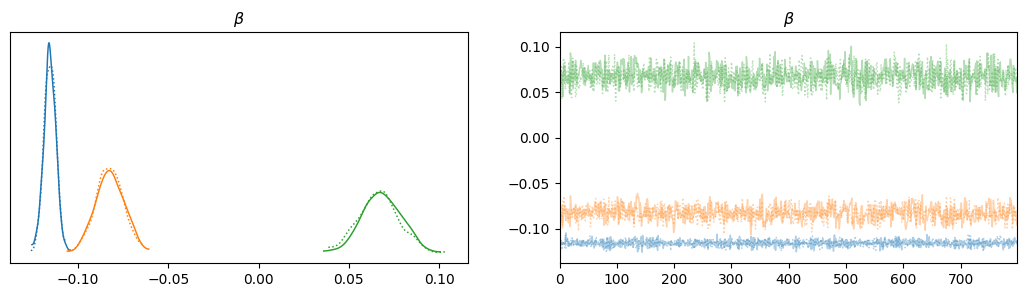

In [22]:
# parameters: beta
labs = az.labels.MapLabeller(var_name_map={"beta": r"$\beta$"})
#az.plot_trace(fourier_az, var_names=["beta"], compact=False, figsize=(15,14), labeller=labs)
az.plot_trace(fourier_az, var_names=["beta"], compact=True, figsize=(13,3), labeller=labs)

plt.show()

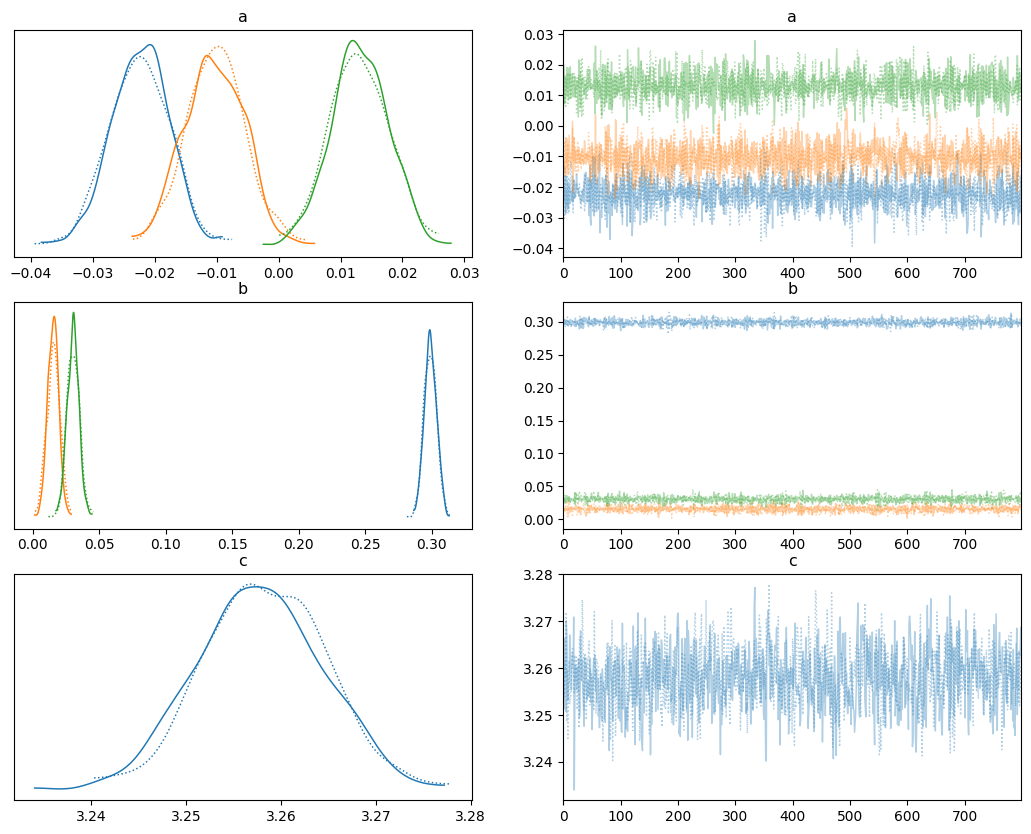

In [23]:
# parameters NON-rural f(t)
#az.plot_trace(fourier_az, var_names=["a", "b", "c"], compact=False, figsize=(15,30))
az.plot_trace(fourier_az, var_names=["a", "b", "c"], compact=True, figsize=(13,10))
plt.show()

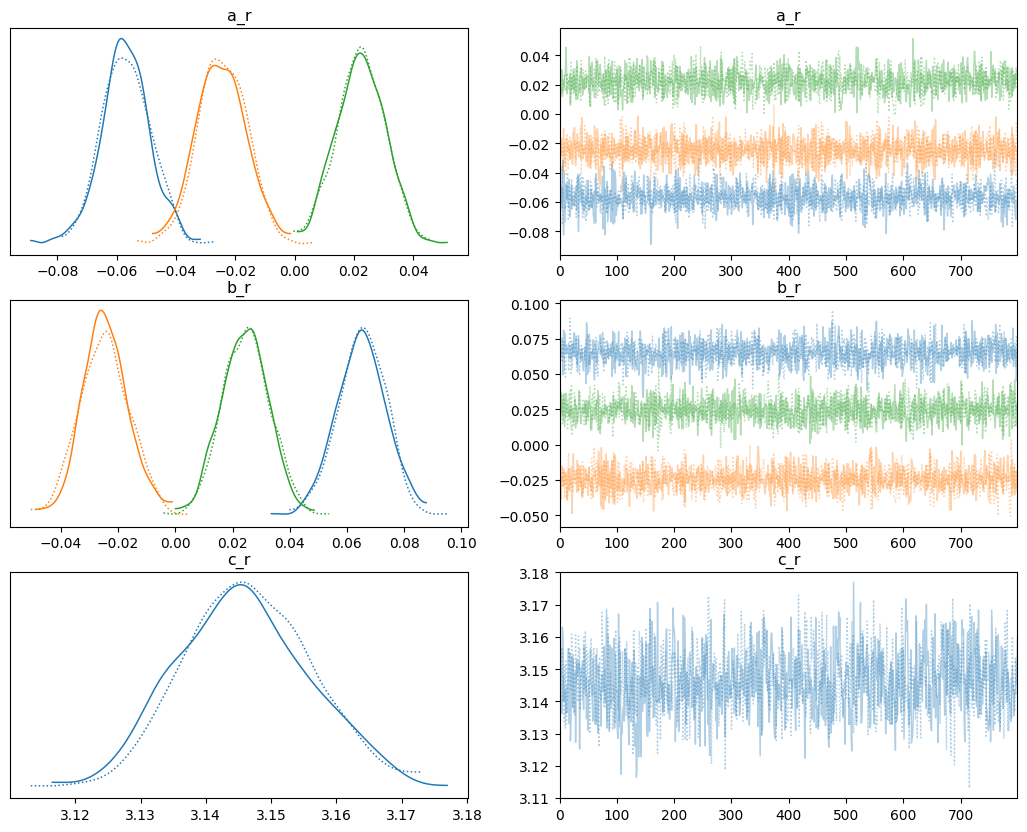

In [24]:
# parameters rural f(t)
#az.plot_trace(fourier_az, var_names=["a_r", "b_r", "c_r"], compact=False, figsize=(15,30))
az.plot_trace(fourier_az, var_names=["a_r", "b_r", "c_r"], compact=True, figsize=(13,10))
plt.show()

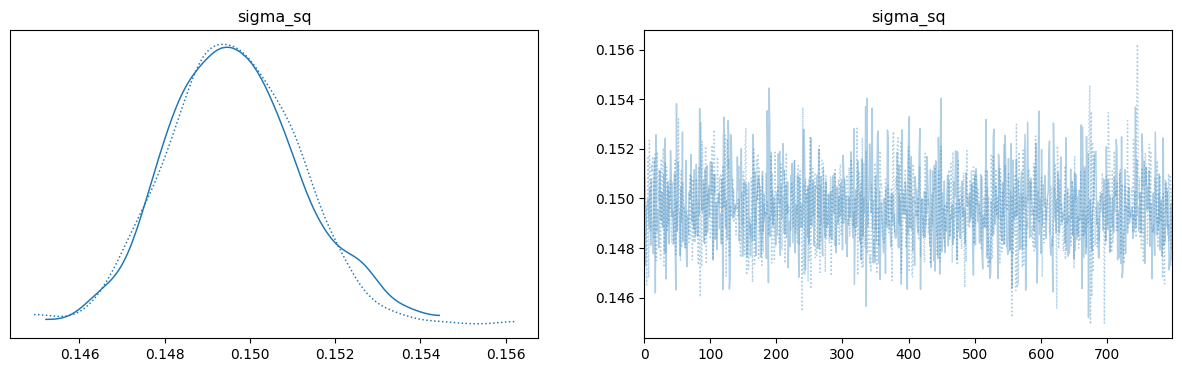

In [25]:
# transformed parameters: sigma^2
az.plot_trace(fourier_az, var_names=["sigma_sq"], figsize=(15,4))
plt.show()

In [26]:
# Divergent iterations: NONE 
np.sum(fourier_az.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
0

In [27]:
# GOF analysis
# WARNING: slow running ~ 2 min
print("WAIC: ", az.waic(fourier_az, var_name="log_lik"))
print("LOO: ", az.loo(fourier_az, var_name="log_lik"))

WAIC:  Computed from 1600 posterior samples and 17836 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -8364.71   107.29
p_waic       19.15        -
LOO:  Computed from 1600 posterior samples and 17836 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -8364.77   107.29
p_loo       19.21        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     17836  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%



***
# SPATIO-TEMPORAL MODELING WITH _STAN_
***

In this second model we add a **spatial residual term <font color='red'>$w$</font>** to include spatial dependence according to the stations' positioning. In order to do so, we import a second data.frame with geo-referenced spatial coordinates of the 49 stations in Emilia-Romagna. We then implement the following model:

$y_i(t) = f_i(t) + X_i \beta + \epsilon_{i,t} +$ <font color='red'>$w_i$</font>, $\qquad \epsilon_{i,t} \sim \mathcal{N}(0, \sigma^2)\ \ $ iid

$f_i(t) = c_k + \sum_{k=0}^{k=K} a_k \sin(k\omega t) + b_k \cos(k\omega t)$

<font color='red'>$w$</font>$\sim \mathcal{N}(0, \alpha H), \qquad H_{i,j} = \exp\{\frac{d_{i,j}^2}{2\rho}\}\ \ $ where $\ \ d_{i,j} = dist(s_i, s_j)$.

where: $i=1,\dots,49$ specifies the station while $t=0,\dots,364$ specifies the day of the year.
To provide **Bayesian posterior inference**, again, we must implement our model in _Stan_ that will provide us **MCMC samplings** to use for posterior densities estimate.

### Input data 
- `int` N = len(Y) = number of total samples 
- `int` K = number of different frequencies for Fourier basis (here K=3)
- `int` p = number of regressors (here p=3 : _quota_ & _tipo_(dummyx2))
- `int` <font color='red'>G</font> = number of stations (here G=49)

- `vector[N]` y = $\log(PM_{10})$ time series
- `matrix[N, p]` x = covariates matrix
- `vector[N]` t = time istant
- `vector[N]` r = 1 if rural, 0 otherwise
- `real` omega = annual frequency = 2$\pi$/365
- `matrix[G, 2]` <font color='red'>coords</font> = coordinates _(lat, long)_ of each station


### Model parameters

- `vector[K]` a =  $\sin(k\omega t)$ coefficients ($k=1,2,3$)
- `vector[K]` b = $\cos(k\omega t)$ coefficients ($k=1,2,3$)
- `real` c = constant term for $f(t)$

- `vector[K]` a_r = $\sin(k\omega t)$ coefficients ($k=1,2,3$) _rural_
- `vector[K]` b_r = $\cos(k\omega t)$ coefficients ($k=1,2,3$) _rural_
- `real` c_r = constant term for $f_r(t)$ _rural_

- `vector[p]` beta = linear regressors' coefficients
- `real` sigma_sq = variance of the error term $\epsilon$
- `vector[G]` <font color='red'>w</font> = spatial residuals, one for each station $g=1,\dots,G$


***
### _Stan_ modeling
***

In [28]:
staz = pd.read_csv("Stazioni_Emilia.csv")
staz.head()

NomeStazione        Lat       Long         Regione  Quota Provincia  \
0         BADIA  44.658309  10.285714  Emilia-Romagna  202.0        PR   
1     BESENZONE  44.987113   9.955758  Emilia-Romagna   50.0        PC   
2      BOGOLESE  44.835555  10.397238  Emilia-Romagna   35.0        PR   
3        CAORLE  44.418868  12.224176  Emilia-Romagna    4.0        RA   
4  CASTELLARANO  44.532199  10.706261  Emilia-Romagna  150.0        RE   

  AreaStazione TipoStazione  id  
0       Rurale        Fondo   1  
1       Rurale        Fondo   2  
2    Suburbano  Industriale   3  
3       Urbano        Fondo   4  
4    Suburbano        Fondo   5

In [29]:
spatial_fourier = """
data {
    int<lower=0> N; 
    int<lower=0> K;
    int<lower=0> p;
    int<lower=0> G;
    
    vector[N] Y;
    matrix[N, p] X;
    vector[N] t;
    vector[N] r;
    array[N] int stazione;
    real omega;
    array[G] vector[2] coord;
}

parameters {

    real<lower=0> sigma_sq;
    
    vector[p] beta;
    
    vector[K] a;
    vector[K] b;
    real c;
    
    vector[K] a_r;
    vector[K] b_r;
    real c_r;
    
    vector[G] w;
    real<lower=0> alpha;
}


transformed parameters {
    
    vector[N] ft = to_vector(rep_array(c, N));
    vector[N] ft_r = to_vector(rep_array(c_r, N));
    
    for (j in 1:K){
     ft += a[j]*sin(j*omega*t) + b[j]*cos(j*omega*t);
     ft_r += a_r[j]*sin(j*omega*t) + b_r[j]*cos(j*omega*t);
     }
     
    cov_matrix[G] H = gp_exp_quad_cov(coord, alpha, 0.0045);
    
    vector[N] mu;
    mu = rows_dot_product(r, ft_r) + rows_dot_product(1-r, ft) + X*beta;
    mu[1:N] += w[stazione[1:N]];
}

model {  

    sigma_sq ~ inv_gamma(3, 2);
    
    beta ~ normal(0, 1);
    
    a ~ normal(0, 1);
    b ~ normal(0, 1);
    c ~ normal(0, 1);
    
    a_r ~ normal(0, 1);
    b_r ~ normal(0, 1);
    c_r ~ normal(0, 1);

    w ~ multi_normal(rep_vector(0,G), H);
    alpha ~ inv_gamma(3, 2);
    
    Y ~ normal(mu, sqrt(sigma_sq));   
}

generated quantities  { 
    vector[N] log_lik;
    for (j in 1:N) {
        log_lik[j] = normal_lpdf(Y[j] | mu[j], sqrt(sigma_sq));
    }
}
"""

stan_file = "./spatial_fourier.stan"

with open(stan_file, "w") as f:
    print(spatial_fourier, file=f)

spatial_fourier = CmdStanModel(stan_file=stan_file)

15:56:53 - cmdstanpy - INFO - compiling stan file /Users/michelafrigeri/Desktop/PDL/spatial_fourier.stan to exe file /Users/michelafrigeri/Desktop/PDL/spatial_fourier
15:57:27 - cmdstanpy - INFO - compiled model executable: /Users/michelafrigeri/Desktop/PDL/spatial_fourier


***
### _Stan_ input data & Sampling
***

In [30]:
y = np.array(df.Y_log)
x = np.matrix( pd.concat([df.quota, dummies.Fondo, dummies.Industriale], axis=1) )
t = np.array(df.Time)
r = np.array(df.Rural)
stazione = np.array(df.id)
omega = 2*np.pi/365
coord = np.matrix( pd.concat([staz.Lat, staz.Long], axis=1) )

N = len(y)
k = 3   # 6 basi di fourier + const
p = 3   # Quota + Tipo(2 dummies)
G = 49  # numero stazioni in Emilia-Romagna



reg_data = {
    "N": N,   # 18 000 circa (49x365)
    "K": k,   # Fbasis number
    "p": p,   # 3
    "G": G,
    
    "Y": y,
    "X": x, 
    "t": t,
    "r": r,
    "stazione": stazione,
    "omega": omega,
    "coord": coord
}

In [31]:
# WARNING: This slot takes some time ~ 30 to 40 minutes
t_start = time.time()

spatial_fit = spatial_fourier.sample(data = reg_data, 
                                     chains = 2, 
                                     parallel_chains = 2,
                                     iter_warmup = 800, 
                                     iter_sampling = 800)

t_elapsed = time.time() - t_start

15:57:28 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

16:25:30 - cmdstanpy - INFO - CmdStan done processing.
16:25:30 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: spatial_fourier_model_namespace::log_prob: H is not symmetric. H[1,2] = nan, but H[2,1] = nan (in 'spatial_fourier.stan', line 46, column 4 to column 60)
	Exception: spatial_fourier_model_namespace::log_prob: H is not symmetric. H[1,2] = nan, but H[2,1] = nan (in 'spatial_fourier.stan', line 46, column 4 to column 60)
Exception: gp_exp_quad_cov: magnitude is 0, but must be positive! (in 'spatial_fourier.stan', line 46, column 4 to column 60)
Consider re-running with show_console=True if the above output is unclear!


In [32]:
print("MCMC sampling of 2 parallel chains terminated in: ", 
      round(math.modf(t_elapsed/60)[1]), "minutes", 
      round(math.modf(t_elapsed/60)[0]*60), "seconds")

MCMC sampling of 2 parallel chains terminated in:  28 minutes 10 seconds


***
### Posterior inference
***

In [33]:
# WARNING: slow running ~ 2 min
spatial_az = az.from_cmdstanpy(spatial_fit)

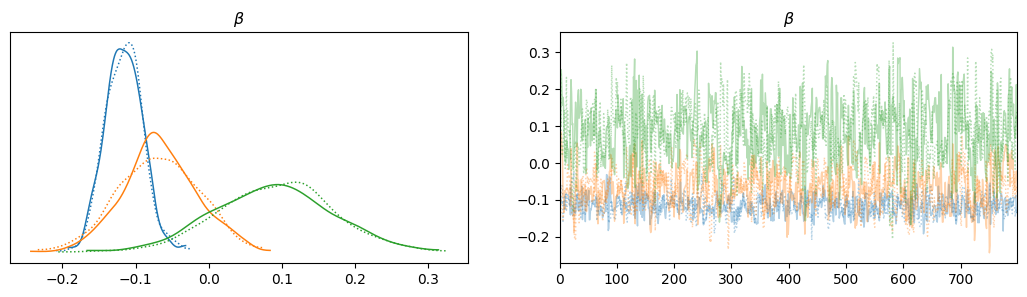

In [34]:
# parameters: beta
labs = az.labels.MapLabeller(var_name_map={"beta": r"$\beta$"})
#az.plot_trace(spatial_az, var_names=["beta"], compact=False, figsize=(15,14), labeller=labs)
az.plot_trace(spatial_az, var_names=["beta"], compact=True, figsize=(13,3), labeller=labs)

plt.show()

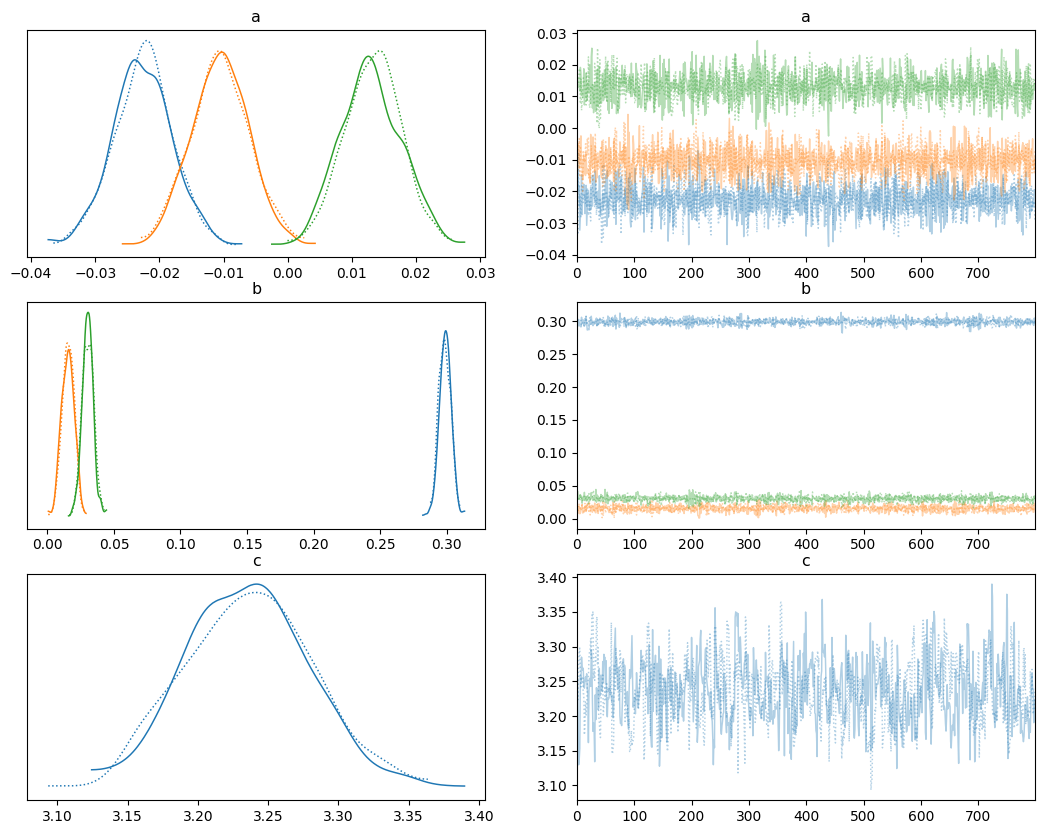

In [35]:
# parameters NON-rural f(t)
#az.plot_trace(spatial_az, var_names=["a", "b", "c"], compact=False, figsize=(15,30))
az.plot_trace(spatial_az, var_names=["a", "b", "c"], compact=True, figsize=(13,10))
plt.show()

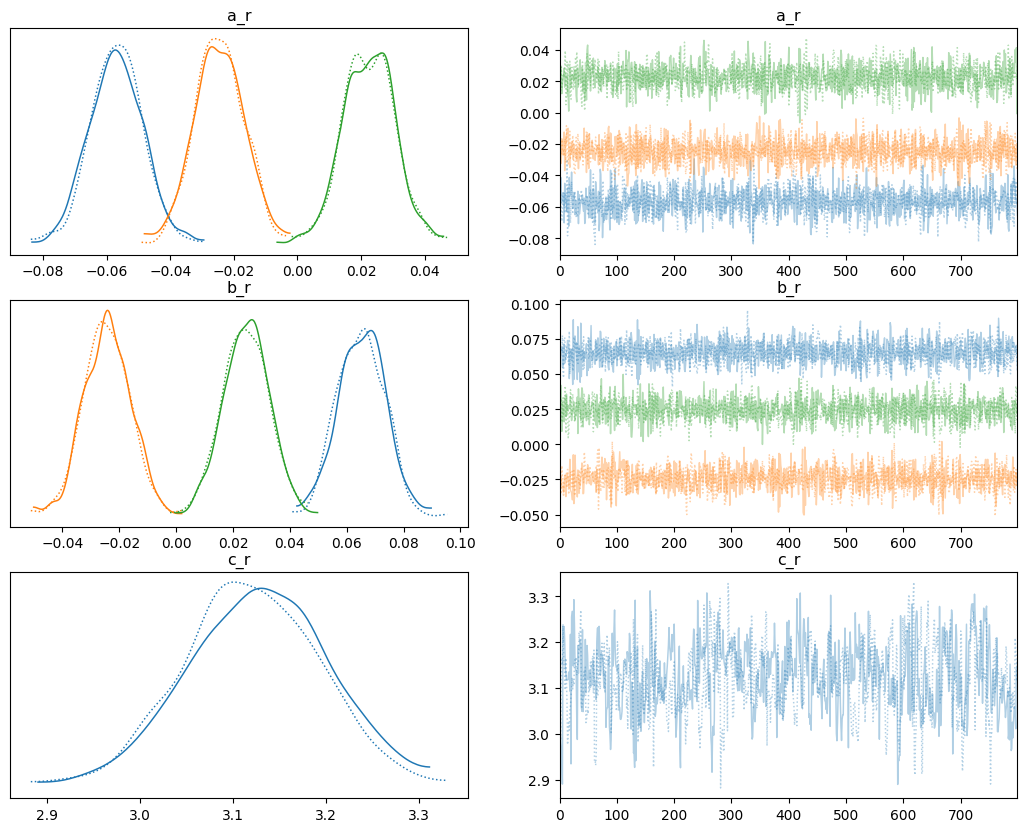

In [36]:
# parameters rural f(t)
#az.plot_trace(spatial_az, var_names=["a_r", "b_r", "c_r"], compact=False, figsize=(15,30))
az.plot_trace(spatial_az, var_names=["a_r", "b_r", "c_r"], compact=True, figsize=(13,10))
plt.show()

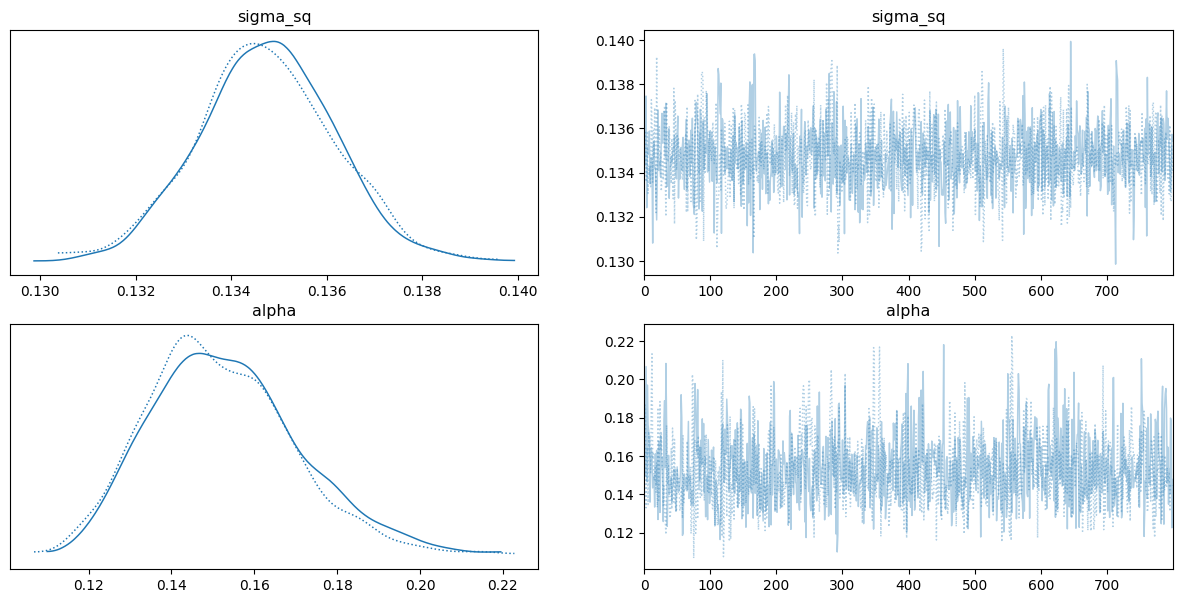

In [37]:
# transformed parameters: sigma^2
az.plot_trace(spatial_az, var_names=["sigma_sq", "alpha"], figsize=(15,7))
plt.show()

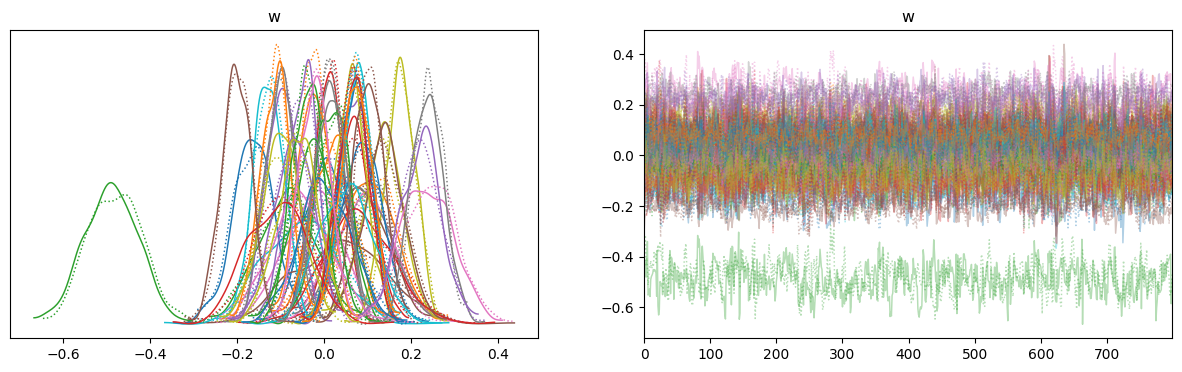

In [38]:
# parameters : wi
az.plot_trace(spatial_az, var_names=["w"], compact=True, figsize=(15,4))
plt.show()

In [39]:
# Divergent iterations? NONE
np.sum(spatial_az.sample_stats.diverging)

<xarray.DataArray 'diverging' ()>
0

In [40]:
# GOF analysis
# WARNING: slow running ~ 2 min
print("WAIC: ", az.waic(spatial_az, var_name="log_lik"))
print("LOO: ", az.loo(spatial_az, var_name="log_lik"))

WAIC:  Computed from 1600 posterior samples and 17836 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -7447.59   108.72
p_waic       62.28        -
LOO:  Computed from 1600 posterior samples and 17836 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -7447.79   108.72
p_loo       62.48        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     17836  100.0%
 (0.5, 0.7]   (ok)           0    0.0%
   (0.7, 1]   (bad)          0    0.0%
   (1, Inf)   (very bad)     0    0.0%



***
# CONCLUSIONS
***

Considering the best performing model for $\log(PM_{10})$ data, i.e. the more complex spatio-temporal modeling framework, we want to study the posterior distributions of parameters.

Specifically, we want to assess the effect of the area type over air pollution and we want to confirm that rural and NON-rural stations are associated to different temporal trends.

In [41]:
# posterior MEDIAN of all parameters in the model
posterior_med = spatial_az.posterior.median(dim=["chain", "draw"])

***
### Linear regressors
***

In [42]:
# CREDIBLE INTERVALS for the linear regressors' coefficients
betas_m = posterior_med.beta.values
betas_hdi = az.hdi(spatial_az, hdi_prob=0.95, var_names="beta")
betas_CI = betas_hdi.beta.values
betas_CI

array([[-0.168141 , -0.0715796],
       [-0.175789 ,  0.029443 ],
       [-0.0774889,  0.242473 ]])

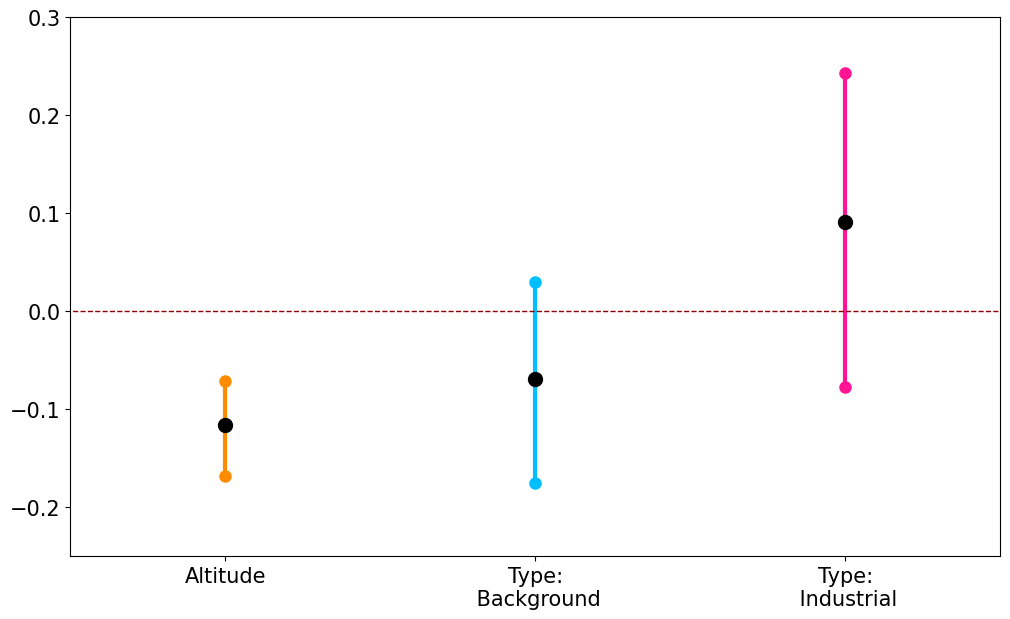

In [43]:
# Posterior betas 95% CI
x = range(1,4)
col = ["darkorange", "deepskyblue", "deeppink"]
plt.figure(figsize=(12,7))
for lu,xi,c in zip(betas_CI, x, col):
    plt.plot((xi, xi), lu, 'o-', color=c, linewidth=3, markersize=8)
plt.xticks(x, ['Altitude', 'Type:\n Background', 'Type:\n Industrial'])
plt.plot(x, betas_m, 'o', color='black', markersize=10, label=['Altitude', 'Type : Background', 'Type : Industrial'])
plt.ylim(-0.25,0.3)
plt.xlim(0.5,3.5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.hlines(0, 0, 4,'darkred', linestyles='dashed', linewidth=1)

#plt.vlines(x, ymin=betas_CI[0], ymax=betas_CI[][1], colors='black', linestyle='--', linewidth=1)

***
### Comparison of $f(t)$ and $f_R(t)$ coefficients
***

In [44]:
# 95% CI : a  vs  a_r
a_m = np.concatenate((posterior_med.a.values, posterior_med.a_r.values), axis=0) 
a_hdi = az.hdi(spatial_az, hdi_prob=0.95, var_names=["a", "a_r"])
a_CI = np.concatenate((a_hdi.a.values, a_hdi.a_r.values), axis=0)

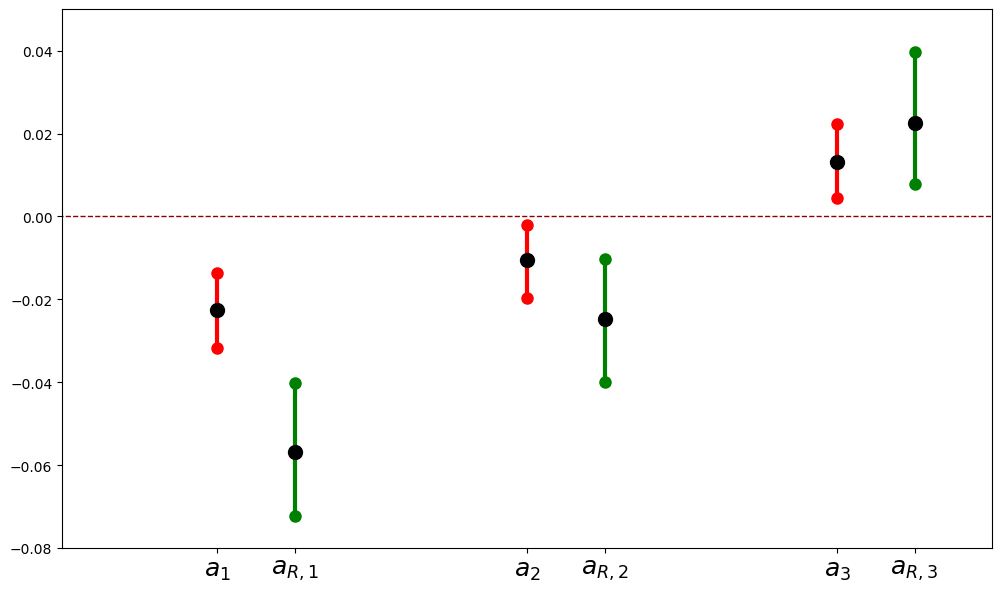

In [45]:
x_a = np.concatenate((np.arange(1,4), np.arange(1,4)+0.25))
col = list(repeat("red", 3)) + list(repeat("green", 3))
plt.figure(figsize=(12,7))
for lu,xi,c in zip(a_CI, x_a, col):
    plt.plot((xi, xi), lu, 'o-', color=c, linewidth=3, markersize=8)
plt.xticks(x_a, ['$a_1$', '$a_2$', '$a_3$', '$a_{R,1}$', '$a_{R,2}$', '$a_{R,3}$'])
plt.plot(x_a, a_m, 'o', color='black', markersize=10)
plt.ylim(-0.08,0.05)
plt.xlim(0.5,3.5)
plt.tick_params(axis='x', which='major', labelsize=18)
plt.hlines(0, 0, 4,'darkred', linestyles='dashed', linewidth=1)

In [46]:
# 95% CI : b  vs  b_r
b_m = np.concatenate((posterior_med.b.values, posterior_med.b_r.values), axis=0) 
b_hdi = az.hdi(spatial_az, hdi_prob=0.95, var_names=["b", "b_r"])
b_CI = np.concatenate((b_hdi.b.values, b_hdi.b_r.values), axis=0)

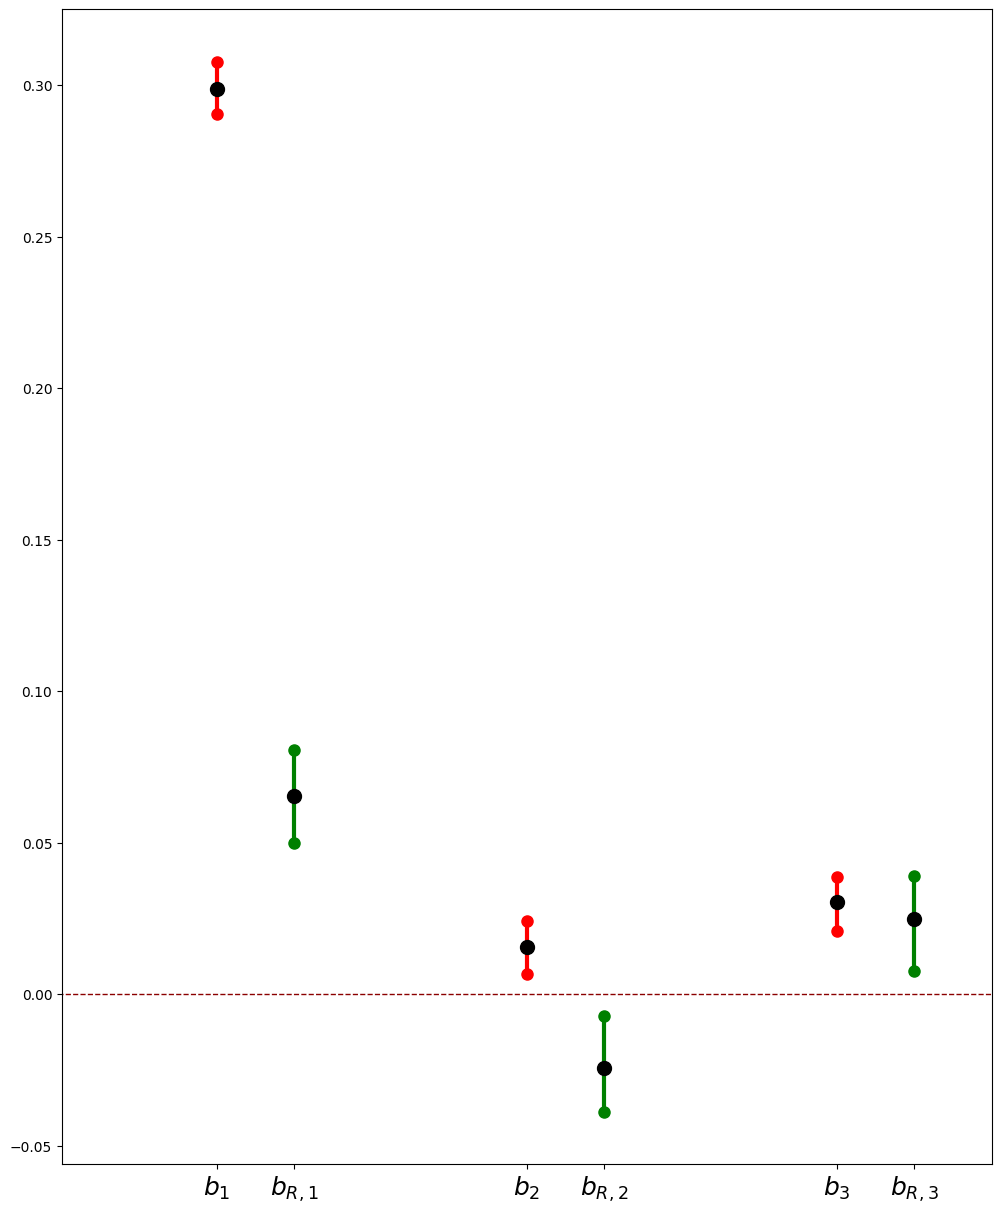

In [47]:
x_b = np.concatenate((np.arange(1,4), np.arange(1,4)+0.25))
col = list(repeat("red", 3)) + list(repeat("green", 3))
plt.figure(figsize=(12,15))
for lu,xi,c in zip(b_CI, x_b, col):
    plt.plot((xi, xi), lu, 'o-', color=c, linewidth=3, markersize=8)
plt.xticks(x_b, ['$b_1$', '$b_2$', '$b_3$', '$b_{R,1}$', '$b_{R,2}$', '$b_{R,3}$'])
plt.plot(x_b, b_m, 'o', color='black', markersize=10)
#plt.ylim(-0.08,0.05)
plt.xlim(0.5,3.5)
plt.tick_params(axis='x', which='major', labelsize=18)
plt.hlines(0, 0, 4,'darkred', linestyles='dashed', linewidth=1)

In [48]:
# 95% CI : c  vs  c_r
c_m = np.array([posterior_med.c.values, posterior_med.c_r.values]) 
c_hdi = az.hdi(spatial_az, hdi_prob=0.95, var_names=["c", "c_r"])
c_CI = np.array([c_hdi.c.values, c_hdi.c_r.values])

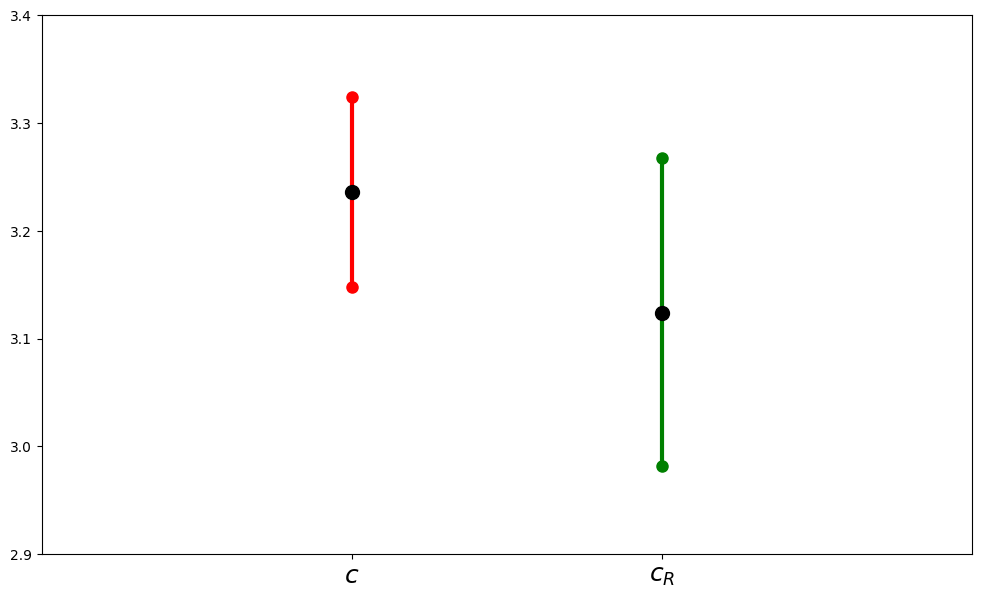

In [49]:
x_c = np.array([1, 1.25])
col = ["red", "green"]
plt.figure(figsize=(12,7))
for lu,xi,c in zip(c_CI, x_c, col):
    plt.plot((xi, xi), lu, 'o-', color=c, linewidth=3, markersize=8)
plt.xticks(x_c, ['$c$','$c_{R}$'])
plt.plot(x_c, c_m, 'o', color='black', markersize=10)
plt.ylim(2.9,3.4)
plt.xlim(0.75,1.5)
plt.tick_params(axis='x', which='major', labelsize=18)
#plt.hlines(0, 0, 4,'darkred', linestyles='dashed', linewidth=1)

***
### Comparison of $f(t)$ and $f_R(t)$ overall trend
***

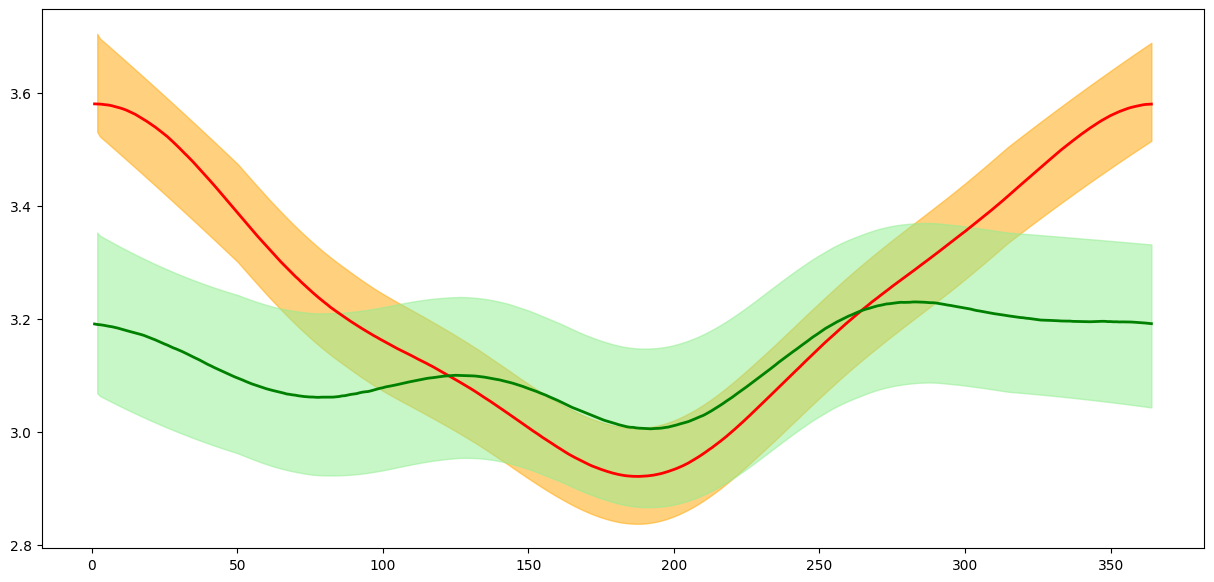

In [50]:
ft_m = posterior_med.ft.values[0:364]
ftR_m = posterior_med.ft_r.values[0:364]
X = range(1,365)
ft = spatial_fit.stan_variable(var='ft')[:, 0:364]
ftR = spatial_fit.stan_variable(var='ft_r')[:, 0:364]
ft_idata = az.from_dict(posterior={"y": ft}, constant_data={"x":X})
ftR_idata = az.from_dict(posterior={"y": ftR}, constant_data={"x":X})
plt.figure(figsize=(15,7))
az.plot_hdi(ft_idata.constant_data.x, ft_idata.posterior.y, color="orange", fill_kwargs={"alpha": .5})
plt.plot(X, ft_m, color='red', linewidth=2)
az.plot_hdi(ftR_idata.constant_data.x, ftR_idata.posterior.y, color="lightgreen", fill_kwargs={"alpha": .5})
plt.plot(X, ftR_m, color='green', linewidth=2)